In [1]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
import numpy as np
import sklearn as sk
import datetime as dt
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn import ensemble
from sklearn.metrics import confusion_matrix, mean_squared_error, auc, accuracy_score, log_loss
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import os
#import graphviz
import matplotlib.pyplot as plt
import pickle
import timeit

In [2]:
%matplotlib inline
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

#set display options
pd.set_option('max_columns', 150)
pd.set_option('max_rows', 110)

In [2]:
#set input/output paths
#can eventually set this to the SOAPY API https://dev.socrata.com/foundry/data.waterpointdata.org/gihr-buz6
DATA_PATH = "~chandler.mccann/Downloads/"
#DATA_PATH = "/Users/chandlermccann/Google Drive/Google Drive/Berkeley MIDS 2016/W210-Capstone_WaterProject"
INPUT_FILE = os.path.join(DATA_PATH, "cleaned_water_data2.csv") #after running prep_water_data.py


In [3]:
df = pd.read_csv(INPUT_FILE)

/Users/chandler.mccann/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (16,32) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
sl = df.loc[df.country_name=='Kenya']

In [5]:
sl.shape

(21109, 40)

In [6]:
features = ['water_source', 'water_tech', 'management',
       'source', 'adm1', 'adm2', 'pay', 'lat_deg', 'lon_deg',
       'new_install_year', 'age_well_years','time_since_meas_years', 'fuzzy_water_source',
        'fuzzy_water_tech','status_binary']

# Modeling

In [7]:
#start_time = timeit.default_timer()

pred_cols = features

#create a copy of the dataframe to label encode
df2 = sl.copy()
df2=df2[pred_cols]

In [8]:
#we can't have any null target values
len(df2[df2.status_binary.isna()==True])


1

In [9]:
#eliminate null target values
df2 = df2[pd.notnull(df['status_binary'])]

/Users/chandler.mccann/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [10]:
#check
len(df2[df2.status_binary.isna()==True])


0

In [11]:
X = df2[df2.columns[:-1]] 
Y= df2.status_binary

X2 = X.copy()

#convert all fields to int labels for XGBoost
lb=LabelEncoder() #instantiate label encoder

#create a dict to store our inverse transforms...these allow us to convert back to the original values in our data
#from collections import defaultdict
#d = defaultdict(LabelEncoder)

#adding this line in order to NOT select lat/lon; other int columns for label encoding
#TO DO - If we have new data coming in we need to invert it at some point
cols = X2.select_dtypes(include=['object']).columns

# Encoding each variable
for col in cols:
    #lb.fit(list(X[col].fillna('___MISSING___').drop_duplicates().values) + ['___MISSING___'])
    
    #X2[col] = lb.transform(X2[col].fillna('___MISSING___'))
    X2[col]= lb.fit_transform(X[col].fillna('__MISSING__'))

In [12]:
#60/20/20 Train/Test/Holdout Split
SEED=7
X_train, X_test_and_holdout, y_train, y_test_and_holdout = sk.model_selection.train_test_split(X2, Y,
                                                                                        test_size=.4,
                                                                                        stratify=Y,
                                                                                        random_state=SEED)
X_test, X_holdout, y_test, y_holdout = sk.model_selection.train_test_split(X_test_and_holdout,
                                                                    y_test_and_holdout,
                                                                    test_size=.5, 
                                                                    stratify= y_test_and_holdout,
                                                                    random_state=SEED)

In [20]:
    ##### Non-Nested Results. Use GridSerach CV on X_Train to find ideal hyper-parameters. Utilize a lot of regularizaiton
    #### in XGBoost Settings to generalize better

# Set gridsearch
print("beggining inner CV...")
#smaller data set, change param grid to less trees
params = {'learning_rate':[0.05,.1], 'max_depth':[3,5,7], 'n_estimators':[500,1000,2000]}
model_inner = model_selection.GridSearchCV(XGBClassifier(scoring='logloss', reg_alpha=0, reg_lambda=1.0,colsample_bylevel=1.0,
                                        colsample_bytree=0.5,gamma=0.01,min_child_weight=1.0, max_delta_step=0.0 ), params)
model_inner.fit(X_train, y_train )

beggining inner CV...


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.5, gamma=0.01, learning_rate=0.1,
       max_delta_step=0.0, max_depth=3, min_child_weight=1.0, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1.0, scale_pos_weight=1, scoring='logloss', seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [3, 5, 7], 'n_estimators': [500, 1000, 2000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [21]:
print('model fit for inner CV for Kenya')
print('Shape of input params= ', X_train.shape)
print('Best searched parameters on inner CV', model_inner.best_params_)
print('Best grid score on inner CV', model_inner.best_score_)



#get auc. 
preds_inner_AUC = model_inner.predict_proba(X_test)[:,1]
preds_inner_accuracy = model_inner.predict(X_test)
print("Accuracy for inner nested_cv model : %.4g"%metrics.accuracy_score(y_test, preds_inner_accuracy))
print("AUC Score (test) for inner_nested cv_model: %f"%metrics.roc_auc_score(y_test, preds_inner_AUC))

#store the best settings from our most recent, regularized XGBoost model above
#perform early stopping
print("beginning")
model_outer = model_inner.best_estimator_
xgb_param =model_outer.get_xgb_params()
xgtrain = xgb.DMatrix(X_train, label=y_train)
#start with 2500 trees and early stop 
#use XGB cross-validation to determine our early stopping parameter
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model_outer.get_params()['n_estimators'], nfold=5,
            metrics='auc', early_stopping_rounds=200)
#set number of trees to where early stopping occurred
model_outer.set_params(n_estimators=cvresult.shape[0])


#Fit the algorithm on the data
model_outer.fit(X_train, y_train,eval_metric='auc')

model fit for inner CV for Kenya
Shape of input params=  (12664, 14)
Best searched parameters on inner CV {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 500}
Best grid score on inner CV 0.873894504106
Accuracy for inner nested_cv model : 0.8742
AUC Score (test) for inner_nested cv_model: 0.836159
beginning


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
       colsample_bytree=0.5, gamma=0.01, learning_rate=0.05,
       max_delta_step=0.0, max_depth=7, min_child_weight=1.0, missing=None,
       n_estimators=298, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1.0, scale_pos_weight=1, scoring='logloss', seed=None,
       silent=True, subsample=1)

In [23]:
#Predict training set:
dtrain_predictions = model_outer.predict(X_train)
dtrain_predprob = model_outer.predict_proba(X_train)[:,1]
dtest_predprob = model_outer.predict_proba(X_test)[:,1]

#predict on the holdout set
dholdout_predprob = model_outer.predict_proba(X_holdout)[:,1]
dholdout_predictions = model_outer.predict(X_holdout)

#Print model report:
print("\nModel Report")
#print("Number of trees determined by early stopping and in final model", cvresult.shape[0])
print("Accuracy for outer nested_cv model on training data: %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
print("AUC Score (Train) for outer nested_cv model: %f" % metrics.roc_auc_score(y_train, dtrain_predprob))
print("AUC Score (Test) for outer nested_cv model: %f" % metrics.roc_auc_score(y_test, dtest_predprob))

print("AUC Score (Holdout) for outer nested_cv model: %f" % metrics.roc_auc_score(y_holdout, dholdout_predprob))
print("Accuracy for outer nested_cv model on holdout data: %.4g" % metrics.accuracy_score(y_holdout.values, 
                                                                                          dholdout_predictions))



Model Report
Accuracy for outer nested_cv model on training data: 0.909
AUC Score (Train) for outer nested_cv model: 0.938668
AUC Score (Test) for outer nested_cv model: 0.836873
AUC Score (Holdout) for outer nested_cv model: 0.833436
Accuracy for outer nested_cv model on holdout data: 0.8761


# ok across test and holdout...drop from train. see if CV is stable

In [22]:
def get_nested_cv_preds(model, X, Y):
    """args: classification model object, fully numeric/ encoded X, target columns
       returns: array of 1) binary classification predictions, 2) probabilities of class membership"""
    #shuffle is necessary. Define same stratified k-fold as before
    #ToDo - fix hard coding of random state, splits, 
    skf= model_selection.StratifiedKFold(n_splits=5, random_state=7, shuffle=True)
    
    print('full data AUC- CV score', sk.model_selection.cross_val_score(model, X, y=Y, scoring='roc_auc',cv=skf))
    cv_results_preds = sk.model_selection.cross_val_predict(model, X, y=Y, cv=skf )
    cv_results_probs = sk.model_selection.cross_val_predict(model, X, y=Y, cv=skf, method ='predict_proba')
    
    print("Accuracy full-data : %.4g" % metrics.accuracy_score(Y, cv_results_preds))
    print("AUC Score full-data: %f" % metrics.roc_auc_score(Y, cv_results_probs[:,1]))
    
    return cv_results_preds, cv_results_probs

In [23]:
get_nested_cv_preds(model_outer,X2,Y)

full data AUC- CV score [ 0.83808151  0.83326082  0.85752035  0.83373562  0.85381135]
Accuracy full-data : 0.8788
AUC Score full-data: 0.842987


(array([ 0.,  0.,  0., ...,  0.,  0.,  0.]), array([[ 0.68207592,  0.31792408],
        [ 0.56600904,  0.43399093],
        [ 0.57495522,  0.42504475],
        ..., 
        [ 0.72186464,  0.27813536],
        [ 0.80715513,  0.19284488],
        [ 0.99156874,  0.00843128]], dtype=float32))

In [24]:
def save_model(model, country):
    filename = '{}_pickle.sav'.format(country)
    pickle.dump(model, open(filename, 'wb'))
    print('saved as', filename)

In [25]:
name = sl.country_name.unique()[0]
save_model(model_outer, name)

saved as Kenya_pickle.sav


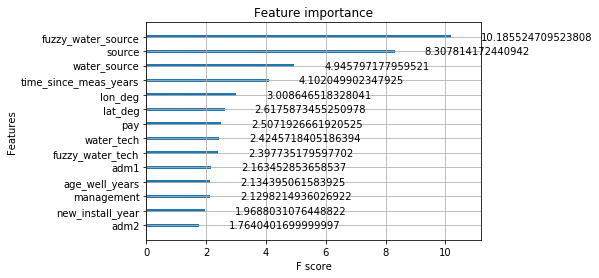

In [59]:
xgb.plot_importance(model_outer, importance_type='gain')

In [63]:
def permutation_importances(model, X_train, y_train, metric):
    baseline = metric( y_train.values,model.predict_proba(X_train))
    imp = []
    for col in X_train.columns:
        save = X_train[col].copy() #store the original
        X_train[col] = np.random.permutation(X_train[col]) #shuffle each column
        m = metric( y_train.values,model.predict_proba(X_train)) #make predictions
        X_train[col] = save # return it back to normal
        imp.append(baseline - m) # if 
    return np.array(imp)

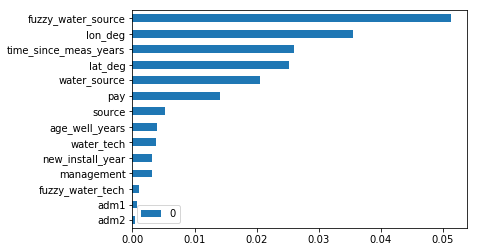

In [66]:
imp = permutation_importances(model_outer, X_test, y_test, metrics.log_loss)

pd.DataFrame(data=abs(imp), index=X_test.columns).sort_values(by=0).plot(kind='barh')

In [67]:
sl.groupby('fuzzy_')['status_binary'].agg(['mean','count']).sort_values(by='count', ascending=False)

,mean,count
fuzzy_water_source,,
__MISSING__ Unknown,0.217780,8830
Well,0.083748,3618
Spring River Stream Protected,0.028830,2428
Borehole,0.126679,2234
Spring River Stream Unprotected,0.020683,2079
no match,0.159391,985
Rain Rainwater,0.122066,426
Stand Post Tap,0.115226,243
Piped,0.056075,107


In [62]:
sl.groupby('source')['status_binary'].size()

source
ACTED                                                                   778
Engineering Sciences & Global Development                               474
Evidence Action                                                       13747
Institute for Sustainable Futures, University of Technology Sydney      142
Living Water International                                              152
MarsabitWater.com With Support From Concern Worldwide                   828
Millennium Water Alliance                                                77
Virtual Kenya                                                          4846
World Vision US                                                          64
Name: status_binary, dtype: int64

# we now how of our early stopped, cross-validated model. We now need to identify the ideal prediction threshold

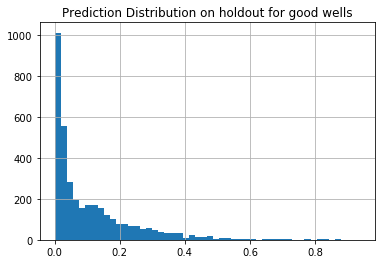

In [27]:
pd.DataFrame(dholdout_predprob[y_holdout==0]).hist(bins=50)
plt.title('Prediction Distribution on holdout for good wells')


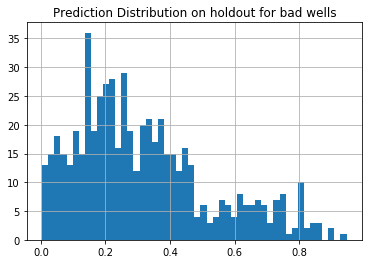

In [28]:
pd.DataFrame(dholdout_predprob[y_holdout==1]).hist(bins=50)
plt.title('Prediction Distribution on holdout for bad wells')


(array([ 1.39418056,  1.46755848,  1.39418056,  1.17404678,  1.8344481 ,
         1.61431433,  2.86173904,  2.05458187,  2.34809357,  2.34809357,
         2.27471565,  1.76107018,  1.24742471,  2.05458187,  1.68769225,
         1.68769225,  1.39418056,  1.24742471,  1.32080263,  1.24742471,
         0.44026754,  0.36688962,  0.36688962,  0.58702339,  0.58702339,
         0.66040132,  0.36688962,  0.58702339,  0.58702339,  0.58702339,
         0.51364547,  0.58702339,  0.07337792,  0.51364547,  0.44026754,
         0.2935117 ,  0.22013377,  0.14675585,  0.        ,  0.07337792]),
 array([ 0.00382186,  0.02739985,  0.05097784,  0.07455582,  0.09813381,
         0.1217118 ,  0.14528979,  0.16886777,  0.19244576,  0.21602375,
         0.23960174,  0.26317973,  0.28675771,  0.3103357 ,  0.33391369,
         0.35749168,  0.38106967,  0.40464765,  0.42822564,  0.45180363,
         0.47538162,  0.49895961,  0.52253759,  0.54611558,  0.56969357,
         0.59327156,  0.61684955,  0.64042753,  0

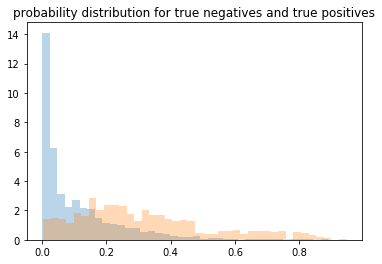

In [29]:

x1 = dholdout_predprob[y_holdout==0]
x2 = dholdout_predprob[y_holdout==1]


kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)

plt.title('probability distribution for true negatives and true positives')
plt.hist(x1, **kwargs)
plt.hist(x2, **kwargs)


### This is not a great distribution. Won't get a recall of 0.9 without a huge FPR

In [37]:
#try a bunch of different prediction thresholds < 0.5 and see which one maximizes recall and F1 score
import numpy as np
d = dict()
for i in np.linspace(0,0.5, num=20):
    best = 0
    test = np.where(dtest_predprob > i, 1,0)
    recall = metrics.recall_score(y_test, test)
    precision = metrics.precision_score(y_test, test)
    f_score = metrics.f1_score(y_test, test, average='binary')
    d[i]=recall, precision, f_score
    
frame = pd.DataFrame.from_dict(d, orient='index')#.columns=(['recall', 'f1_score'])
frame.columns=(['recall','precision', 'f1_score'])
frame[frame.recall>0.5]

,recall,precision,f1_score
0.000000,1.000000,0.136665,0.240467
0.026316,0.960139,0.192228,0.320324
0.052632,0.916811,0.228806,0.366217
0.078947,0.878683,0.250742,0.390150
0.105263,0.845754,0.269019,0.408197
0.131579,0.800693,0.299805,0.436261
0.157895,0.738302,0.327945,0.454158
0.184211,0.698440,0.354754,0.470520
0.210526,0.656846,0.378244,0.480051
0.236842,0.599653,0.397701,0.478231


In [38]:
#try a bunch of different prediction thresholds < 0.5 and see which one maximizes recall and F1 score
import numpy as np
d = dict()
for i in np.linspace(0,0.5, num=20):
    best = 0
    test = np.where(dholdout_predprob > i, 1,0)
    recall = metrics.recall_score(y_holdout, test)
    precision = metrics.precision_score(y_holdout, test)
    f_score = metrics.f1_score(y_holdout, test, average='binary')
    d[i]=recall, precision, f_score
    
frame = pd.DataFrame.from_dict(d, orient='index')#.columns=(['recall', 'f1_score'])
frame.columns=(['recall','precision', 'f1_score'])
frame[frame.recall>0.5]

,recall,precision,f1_score
0.000000,1.000000,0.136902,0.240833
0.026316,0.972318,0.191547,0.320046
0.052632,0.930796,0.227196,0.365241
0.078947,0.894464,0.247724,0.387992
0.105263,0.859862,0.269962,0.410914
0.131579,0.818339,0.300317,0.439387
0.157895,0.745675,0.325775,0.453446
0.184211,0.692042,0.348432,0.463499
0.210526,0.633218,0.366000,0.463878
0.236842,0.572664,0.387588,0.462291


## Modeling Decision: Threshold of 0.25 gives a recall > 0.55 and a precision > 0.4on both test and holdout. Will use as threshold. We want to have a high recall rate but need to make a trade off with FPR

##### Create predictions for the out years based on data

In [15]:
model_outer=pickle.load(open('Kenya_pickle.sav', 'rb'))

In [16]:
X_today = X2.copy()
X_today['age_well_years'] = X_today.age_well_years + X_today.time_since_meas_years
X_today[:1]

,water_source,water_tech,management,source,adm1,adm2,pay,lat_deg,lon_deg,new_install_year,age_well_years,time_since_meas_years,fuzzy_water_source,fuzzy_water_tech
39068,58,102,9,8,9,25,122,0.0926,36.1744,80,278.8,4.8,10,1


In [17]:
#make two other future values to predict, 1 year and 5 years
X_1year = X_today.copy()
X_1year['age_well_years'] = X_1year.age_well_years + 1
X_3year = X_1year.copy()
X_3year['age_well_years']=X_3year.age_well_years+2
X_5year = X_1year.copy()
X_5year['age_well_years']=X_5year.age_well_years+4

In [18]:
print(X2[['age_well_years', 'time_since_meas_years']][:1])
print(X_today['age_well_years'][:1])
print(X_1year['age_well_years'][:1])
print(X_3year['age_well_years'][:1])
print(X_5year['age_well_years'][:1])

       age_well_years  time_since_meas_years
39068           274.0                    4.8
39068    278.8
Name: age_well_years, dtype: float64
39068    279.8
Name: age_well_years, dtype: float64
39068    281.8
Name: age_well_years, dtype: float64
39068    283.8
Name: age_well_years, dtype: float64


# Get Predictions for Today, 1, 3 and 5 years out

In [19]:
today_preds = model_outer.predict(X_today)
today_predprob = model_outer.predict_proba(X_today)
one_year_preds = model_outer.predict(X_1year)
one_year_predprob = model_outer.predict_proba(X_1year)
three_year_preds = model_outer.predict(X_3year)
three_year_predprob = model_outer.predict_proba(X_3year)
five_year_preds = model_outer.predict(X_5year)
five_year_predprob = model_outer.predict_proba(X_5year)

In [20]:
# append them to the original df
#erroring, since we had to drop a few NaN rows
sl = df2
sl['today_preds']=today_preds
sl['today_predprob']= today_predprob[:,1]
sl['one_year_preds'] = one_year_preds
sl['one_year_predprob'] = one_year_predprob[:,1]
sl['three_year_preds'] = three_year_preds
sl['three_year_predprob']= three_year_predprob[:,1]
sl['five_year_preds']=five_year_preds
sl['five_year_predprob'] =five_year_predprob[:,1]

In [48]:
#original before corrected time to measure
sl[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,21108.000000,21108.000000,21108.000000,21108.000000,21108.000000
mean,0.136725,0.046381,0.043254,0.046854,0.052634
std,0.343565,0.210313,0.203433,0.211332,0.223307
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [21]:
# with corrected time to measure
sl[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,21108.000000,21108.000000,21108.000000,21108.000000,21108.000000
mean,0.136725,0.046381,0.046381,0.045575,0.045717
std,0.343565,0.210313,0.210313,0.208567,0.208876
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


# 0.5 threshold won't do, setting a modeling decision of > 90% recall for our prediction threshold

In [22]:
threshold = 0.25
#recall > 90%, we want to catch all of the bad wells
sl['today_preds']=np.where(today_predprob[:,1]>threshold,1,0)
sl['today_predprob']= today_predprob[:,1]
sl['one_year_preds'] = np.where(one_year_predprob[:,1]>threshold,1,0)
sl['one_year_predprob'] = one_year_predprob[:,1]
sl['five_year_preds']=np.where(five_year_predprob[:,1]>threshold,1,0)
sl['five_year_predprob'] =five_year_predprob[:,1]

In [50]:
#old results before time to measure correction
sl[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,21108.000000,21108.000000,21108.000000,21108.000000,21108.000000
mean,0.136725,0.175147,0.201535,0.046854,0.236498
std,0.343565,0.380102,0.401156,0.211332,0.424941
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
#new results after adjusting time since measurement
sl[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,21108.000000,21108.000000,21108.000000,21108.000000,21108.000000
mean,0.136725,0.175147,0.174720,0.045575,0.175289
std,0.343565,0.380102,0.379737,0.208567,0.380223
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
#how many wells that were good at time of measurement do we predict will fail within one year from today?
sl[sl.status_binary==0][(sl.today_preds<sl.one_year_preds)].shape

(795, 23)

In [52]:
#how many wells that were good at time of measurement do we predict will fail within one year from today?
sl[sl.status_binary==0][(sl.today_preds<sl.one_year_preds)&(sl.one_year_preds<sl.three_year_preds)].shape

(0, 23)

In [53]:
print(metrics.classification_report(y_holdout, dholdout_predictions))

             precision    recall  f1-score   support

        0.0       0.88      0.98      0.93      3644
        1.0       0.62      0.18      0.28       578

avg / total       0.85      0.87      0.84      4222



In [54]:
sl.to_csv('Kenya_w_outyear_predictions.csv')

In [24]:
gp = sl.groupby(['fuzzy_water_source', 'fuzzy_water_tech', 'status_binary']).size().unstack()
gp['percentage_broken'] = round(gp[1]/gp.sum(axis=1)*100,2)
gp.reset_index(inplace=True)
gp.rename(columns={0:'# functioning', 1:'# not functioning'},index={'status_binary':'index'},  inplace=True)
gp.rename_axis('index', axis='columns').fillna(0)

index,fuzzy_water_source,fuzzy_water_tech,# functioning,# not functioning,percentage_broken
0,Borehole,Afridev,441.0,76.0,14.70
1,Borehole,Borehole,0.0,1.0,100.00
2,Borehole,Bush Pump,43.0,17.0,28.33
3,Borehole,Electrical Pump,375.0,23.0,5.78
4,Borehole,Gravity,2.0,0.0,0.00
5,Borehole,Hand Pump,308.0,87.0,22.03
6,Borehole,India Mark MK IMK II,79.0,10.0,11.24
7,Borehole,__MISSING__,632.0,61.0,8.80
8,Borehole,no match,71.0,8.0,10.13
9,Lake Pond Dam,Bucket,1.0,1.0,50.00


# Ensure that if a waterpoint was ever bad in the past, it will always be bad in the future

In [25]:
def append_outyear_predictions(original_df, threshold, today_predprob, one_year_predprob, three_year_predprob, five_year_predprob):
    sl = original_df.copy()
    #ensures if a well was ever bad, it is bad in the future
    sl['today_preds']=np.where(sl.status_binary==1,1,np.where(today_predprob[:,1]>threshold,1,0))
    sl['today_predprob']= today_predprob[:,1]
    sl['one_year_preds'] = np.where(np.max(sl[['status_binary','today_preds']], axis = 1)>0,
                                    1,np.where(one_year_predprob[:,1]>threshold,1,0))
    sl['one_year_predprob'] = one_year_predprob[:,1]
    sl['three_year_preds'] = np.where(np.max(sl[['status_binary','today_preds', 'one_year_preds']], axis = 1)>0,1,
                                      np.where(three_year_predprob[:,1]>threshold,1,0))
    sl['three_year_predprob']= three_year_predprob[:,1]
    sl['five_year_preds']=np.where(np.max(sl[['status_binary','today_preds', 'one_year_preds', 'three_year_preds']], axis = 1)>0,
                                   1,np.where(five_year_predprob[:,1]>threshold,1,0))
    sl['five_year_predprob'] =five_year_predprob[:,1]
    
    
    return sl

In [26]:
kenya = df.loc[df.country_name=='Kenya']
kenya = kenya[pd.notnull(kenya['status_binary'])]

In [84]:
coerced = append_outyear_predictions(kenya, 0.25, today_predprob, one_year_predprob, three_year_predprob, five_year_predprob)

In [27]:
coerced2 = append_outyear_predictions(kenya, 0.25, today_predprob, one_year_predprob, three_year_predprob, five_year_predprob)

In [85]:
#old results

coerced[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,21108.000000,21108.000000,21108.000000,21108.000000,21108.000000
mean,0.136725,0.220343,0.258006,0.280226,0.288943
std,0.343565,0.414488,0.437548,0.449120,0.453282
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
#new results after adjusting time to measure
coerced2[['status_binary','today_preds','one_year_preds','three_year_preds', 'five_year_preds']].describe()

,status_binary,today_preds,one_year_preds,three_year_preds,five_year_preds
count,21108.000000,21108.000000,21108.000000,21108.000000,21108.000000
mean,0.136725,0.220343,0.220769,0.221527,0.221859
std,0.343565,0.414488,0.414775,0.415284,0.415507
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [86]:
coerced.to_csv('Kenya_w_outyear_predictions_coerced.csv')

In [30]:
coerced2.to_csv('Kenya_w_outyear_predictions_coerced_correct_time2.csv')

In [34]:
coerced2.installer.describe()

count           21108
unique             38
top       __MISSING__
freq            20830
Name: installer, dtype: object